[]
Individual Accuracies per Model and Dataset:


,Model,Dataset,Accuracy



Aggregated Accuracy across Models:


,Model,Accuracy


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


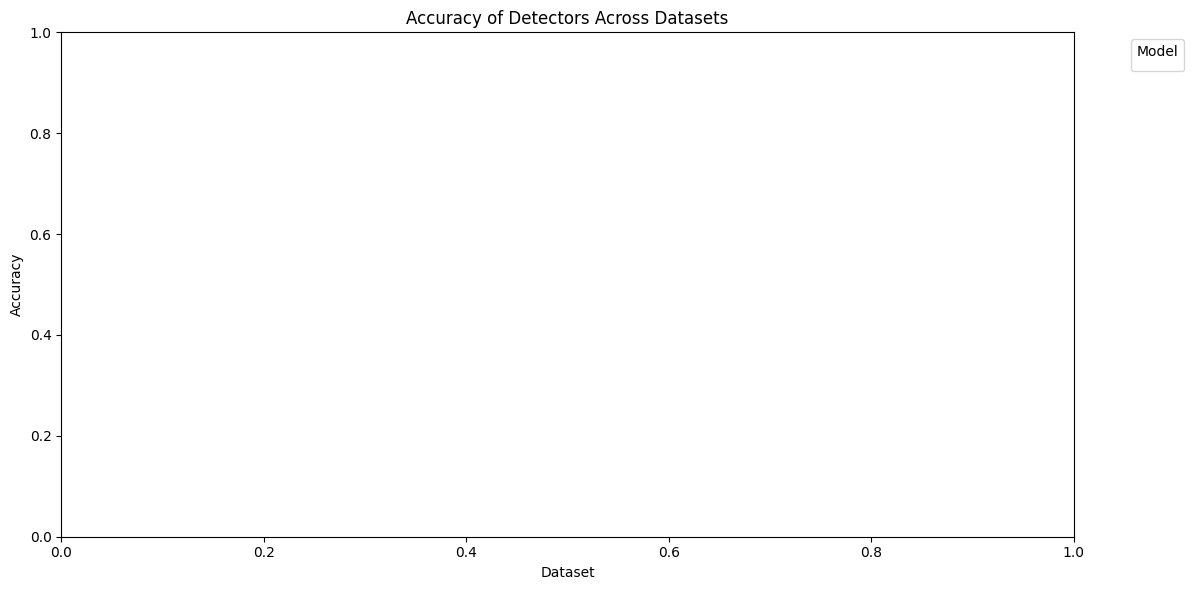

In [12]:
import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score
from pathlib import Path

# Specify the folder containing the CSV files
folder_path = "..\csv\\"  # Replace with your actual folder path
# Define the threshold for considering an image as synthetic
probability_threshold = 0.2

def logits_to_probabilities(logits):
    return 1 / (1 + np.exp(-logits))

def calculate_model_accuracy(df, threshold):
    accuracies = {}
    for model_name, column in model_columns.items():
        pred_column = f'{model_name}_pred'
        prob_column = f'{model_name}_prob' if 'exif' not in model_name else column
        df[pred_column] = df[prob_column] > threshold
        accuracies[model_name] = accuracy_score(df['true_label'], df[pred_column])

    # Aggregate results
    prediction_columns = [f'{model}_pred' for model in model_columns.keys()]
    df['final_pred'] = df[prediction_columns].any(axis=1)
    accuracies['aggregate'] = accuracy_score(df['true_label'], df['final_pred'])

    return accuracies

# Construct the pattern to match all CSV files in the folder
pattern = os.path.join(folder_path, '*.csv')
print(pattern)

# Use glob to find all files matching the pattern
csv_files = glob.glob(pattern)
print(csv_files)

# List of CSV files for each dataset
accuracy_across_datasets = {model: [] for model in ['logits_Grag2021_progan', 'logits_Grag2021_latent', 'resnet50nodown_progan', 'resnet50nodown_stylegan2', 'exif_model', 'aggregate']}

# Loop through each CSV file
for csv_file_name in csv_files:
    input = Path("..", "csv", csv_file_name)  # Adjust the path as necessary

    # Load the data from the CSV file
    df = pd.read_csv(input)

    # Applying sigmoid function to convert logits to probabilities
    model_columns = {
        'logits_Grag2021_progan': 'dMDetectorResultsinferenceResults_logits_Grag2021_progan',
        'logits_Grag2021_latent': 'dMDetectorResultsinferenceResults_logits_Grag2021_latent',
        'resnet50nodown_progan': 'gANDetectorResultsinferenceResults_logits_gandetection_resnet50nodown_progan',
        'resnet50nodown_stylegan2': 'gANDetectorResultsinferenceResults_logits_gandetection_resnet50nodown_stylegan2',
        'exif_model': 'exifDetectorResultsinferenceResults_isSyntheticImage'
    }

    for model_name, column in model_columns.items():
        if 'exif' not in model_name:  # Exif model doesn't need conversion
            df[f'{model_name}_prob'] = logits_to_probabilities(df[column])

    # Calculate model accuracy
    model_accuracies = calculate_model_accuracy(df, probability_threshold)

    # Store accuracies for each model across datasets
    for model, acc in model_accuracies.items():
        accuracy_across_datasets[model].append(acc)

    print(f"Processed data for {csv_file_name}!")

# Creating a DataFrame for accuracies across datasets
accuracy_across_df = pd.DataFrame.from_dict(accuracy_across_datasets, orient='index', columns=csv_files)
accuracy_across_df = accuracy_across_df.reset_index().melt(id_vars='index', var_name='Dataset', value_name='Accuracy')
accuracy_across_df.rename(columns={'index': 'Model'}, inplace=True)

# Print a readable table for individual accuracy
print("Individual Accuracies per Model and Dataset:")
display(accuracy_across_df)

# Calculate and print the aggregated accuracy across models
aggregated_accuracy_df = accuracy_across_df.groupby('Model')['Accuracy'].mean().reset_index()
print("\nAggregated Accuracy across Models:")
display(aggregated_accuracy_df)

# Plotting Accuracy Across Datasets
plt.figure(figsize=(12, 6))
sns.barplot(x='Dataset', y='Accuracy', hue='Model', data=accuracy_across_df)
plt.title('Accuracy of Detectors Across Datasets')
plt.xlabel('Dataset')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()
